# Oxford Man Institute NLP Tutorial 

## 1. Introduction 

There are several ways of performing sentiment classification on a document or article, ranging from word-counts to modern Transformer-based Language Models. In this tutorial we will take you through a range of classification techniques:
- Loughran & McDonald financial sentiment dictionary
- Naive Bayes Classifier
- BERT out of the box
- BERT fine-tuned on general sentiment datasets
- FinBERT 
    - BERT that has been trained on positive and negative financial documents

## 2. Traditional sentiment analysis

### Import packages and load dictionaries

In [1]:
import numpy as np
import re

### Loughran & McDonald classifier

Loughran & McDonald released their master dictionary in 2011 in conjunction with their paper “When is a Liability not a Liability? Textual Analysis, Dictionaries, and 10-Ks". The dictionary lists a number of words and includes negative, positive, uncertainty, litigious, strong modal, weak modal, and constraining tags. 

There are several shortcomings to this simplistic approach:

- **Some words don't appear in the dictionary (fall, rise, etc.)**
- **Some words are negative/positive given the context they are written (profit, expenditure, etc.)**
- **Simple counts of words don't necessarily infer the overall sentiment**
    - *Hatred for football has always confused me; there are so many haters who attack the sport, but I have always loved it.* - 3 negative words and 1 positive word.


We have taken the words that have a negative and positive tag for our classifier:

In [2]:
lmdict = np.load('data/LoughranMcDonald_dict.npy', allow_pickle='TRUE').item()
print('Some examples of negative words: ', lmdict['Negative'][:5])
print('Some examples of positive words: ', lmdict['Positive'][:5])

Some examples of negative words:  ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments']
Some examples of positive words:  ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish']


In [3]:
lmdict['Positive'][:5]

['able', 'abundance', 'abundant', 'acclaimed', 'accomplish']

Check to see if a word appears in the dictionary:

In [4]:
word = 'fall'

if word in lmdict['Negative']:
    print(f'Yes, {word} is a Negative word in the Loughran & McDonald dictionary')
elif word in lmdict['Positive']:
    print(f'Yes, {word} is Positive word in the Loughran & McDonald dictionary')
else:
    print(f'No, {word} is not in the Loughran & McDonald dictionary')

No, fall is not in the Loughran & McDonald dictionary


Negation is another challenge that emerges using this approach. A techy fix is to check if the word is preceeded by a negating word in our list:

In [5]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [6]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

This function counts the number of negative and positive words in a document and performs a negation check to switch the polarity of words that are preceeded by a word in the *negate* list.

In [7]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    print('The results with negation check:', end='\n\n')
    print('The # of positive words:', pos_count)
    print('The # of negative words:', neg_count)
    print('The list of found positive words:', pos_words)
    print('The list of found negative words:', neg_words)
    print('\n', end='')
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results
 
    
# A sample output
article = '''Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing not able abandon'''
 
tone_count_with_negation_check(lmdict, article)

The results with negation check:

The # of positive words: 0
The # of negative words: 2
The list of found positive words: []
The list of found negative words: ['able (with negation)', 'abandon']



[26, 0, 2, [], ['able (with negation)', 'abandon']]

## 3. BERT classification

In [1]:
# Import all dependencies 
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import  TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import AutoConfig
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the dataset from huggingfaces' dataset repository
#fin_dataset = load_dataset('financial_phrasebank', 'sentences_allagree')
#df = pd.DataFrame(fin_dataset['train']) # send  it to a pandas dataframe

# HUGE INSTALL PROBLEM ON WINDOWS NEED TO FIX - RUNS FINE ON MAC - 

# MEANTIME INSTALL FROM data/FinancialPhraseBanl-v1.0

df = pd.read_csv('data\\FinancialPhraseBank-v1.0\\Sentences_50Agree.txt',
            encoding = 'ISO-8859-1',on_bad_lines='skip',sep = '.@')
df.columns = ['sentence','label']

In [3]:
df['label'] = df['label'].replace(to_replace=({'neutral':0,'positive':1,'negative':2}))
df['label']= df['label'].astype(int)

In [4]:
### Tokenizer 

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [6]:
#how does the tokenizer work ? 
print('\nThis is our input sentence : \n Hi my name is BERT and I am overjoyed  to meet you ! \n')

out = tokenizer(['Hi my name is BERT and I am overjoyed  to meet you ! '],
          max_length=64,padding="max_length", truncation=True,return_tensors='pt')
print('These are the outputs of the tokenizer:\n')
print(out)

print('\nThese inputs correspond to the original sentence with separation and padding thrown in :\n')
print([tokenizer.decode(i) for i in out['input_ids']])


This is our input sentence : 
 Hi my name is BERT and I am overjoyed  to meet you ! 

These are the outputs of the tokenizer:

{'input_ids': tensor([[  101,  8790,  1139,  1271,  1110,   139,  9637,  1942,  1105,   146,
          1821,  1166, 18734,  1174,  1106,  2283,  1128,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
     

In [7]:
# Now that we covered  the tokenizer lets introduce the other building block : the model 

print('this is our model : \n')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')
layers = [i for i in model.parameters()]
print('\n First layer shape (vocabulary size) : \n ',layers[0].shape,
'\n Last layer shape (prediction task output shape) : \n ',layers[-1].shape)

this is our model : 



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b


 First layer shape (vocabulary size) : 
  torch.Size([28996, 768]) 
 Last layer shape (prediction task output shape) : 
  torch.Size([2])


In [8]:
# basic forward propagation of our BERT model 
print('This is our forward propagation syntax. \n We feed in a tokenized text and receive the \n predicted  logits over the 2 classes : \n')
model.forward(**out)

This is our forward propagation syntax. 
 We feed in a tokenized text and receive the 
 predicted  logits over the 2 classes : 



SequenceClassifierOutput(loss=None, logits=tensor([[-0.6428,  0.3938]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [9]:
# Working with BERT hands-on 

In [10]:
#  define tokenizer & model 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# turn the configuration for a 3 sentiment classification task
config = AutoConfig.from_pretrained('bert-base-cased')
config.num_labels = 3

model = AutoModelForSequenceClassification.from_config(config)


In [11]:
train, test = train_test_split(df, test_size=0.25, random_state=96)
test, val = train_test_split(test, test_size=0.4, random_state=96)

In [12]:
# Defining a Dataset object to put our data in


class BERTTutorialDataset(Dataset):
    """
    Special dataset class built on top of the torch Dataset class
    useful to have memory efficient dataloading tokenization batching and trainning.
    
    Huggingface can use these types of dataset as inputs and run all trainning/prediction on them. 
    """
    def __init__(self, input_data, sentiment_targets, tokenizer, max_len):
        """
        Basic generator function for the class.
        -----------------
        input_data : array
            Numpy array of string  input text to use for downstream task 
        sentiment_targets : 
            Numpy array of integers indexed in  the pytorch style of [0,C-1] with C being the total number of classes
            In our example this means the target sentiments should range from 0 to 2. 
        tokenizer  : Huggingface tokenizer 
            The huggingface tokenizer to use
        max_len : 
            The truncation length of the tokenizer 
        -------------------
        
        Returns : 
        
            Tokenized text with inputs, attentions and labels, ready for the Training script. 
        """
        self.input_data = input_data
        self.sentiment_targets = sentiment_targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        """
        Function required by torch huggingface to batch efficiently
        """
        return len(self.input_data)
    
    def __getitem__(self, item):
        text = str(self.input_data[item])
        target = self.sentiment_targets[item]
        # only difference with the previuous tokenization step is the encode-plus for special tokens
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation = True
        )
        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(target, dtype=torch.long)
        }

In [13]:
# Creating our train-val-test datasets
MAX_LEN = 128
train_ds = BERTTutorialDataset(
    input_data=train['sentence'].to_numpy(),
        sentiment_targets=train['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
val_ds = BERTTutorialDataset(
    input_data=val['sentence'].to_numpy(),
        sentiment_targets=val['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

test_ds = BERTTutorialDataset(
    input_data=test['sentence'].to_numpy(),
        sentiment_targets=test['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )


In [19]:
# Define some accuracy measure ( helpful for the early stopping )
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
def compute_metrics(p):
    """
    Function to calculate accuracies and losses for the validation from the predicted outputs
    This is neccessary for the early stopping. 
    """
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [21]:
# Define trainning arguments 
training_args = TrainingArguments('BERT_TUTORIAL_MODEL', overwrite_output_dir=True, evaluation_strategy="steps", 
                                  num_train_epochs=50, weight_decay=0.005,learning_rate=1e-5,
                                  eval_steps=200,metric_for_best_model='accuracy',
                                 per_device_train_batch_size=16, per_device_eval_batch_size=16,
                                 load_best_model_at_end = True, save_total_limit=10, save_steps=200,no_cuda=False,
                             fp16=True,gradient_accumulation_steps=4)
trainer = Trainer(
    model =pretrained, args=training_args, train_dataset=train_ds, eval_dataset=val_ds,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=20)], compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [32]:
trainer.train()

***** Running training *****
  Num examples = 3633
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 2850


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,No log,0.931204,0.616495,0.205498,0.333333,0.254252
400,No log,0.912291,0.616495,0.205498,0.333333,0.254252
600,0.936900,0.912117,0.616495,0.205498,0.333333,0.254252
800,0.936900,0.929159,0.616495,0.205498,0.333333,0.254252
1000,0.936700,0.910936,0.616495,0.205498,0.333333,0.254252
1200,0.936700,0.921764,0.616495,0.205498,0.333333,0.254252
1400,0.936700,0.909856,0.616495,0.205498,0.333333,0.254252
1600,0.935400,0.912583,0.616495,0.205498,0.333333,0.254252
1600,0.935400,0.938188,0.583219,0.194406,0.333333,0.245584


***** Running Evaluation *****
  Num examples = 485
  Batch size = 16
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-200
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-200\config.json
Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-200\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-90] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 485
  Batch size = 16
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-400
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-400\config.json
Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-400\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 485
  Batch size = 16
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-600
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-600\config.json
Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-600\p

RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:300] . unexpected pos 40576 vs 40516

In [22]:
trainer.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 727
  Batch size = 16


{'eval_loss': 0.9347929358482361,
 'eval_accuracy': 0.5832187070151307,
 'eval_precision': 0.19440623567171023,
 'eval_recall': 0.3333333333333333,
 'eval_f1': 0.245583550535766,
 'eval_runtime': 5.4939,
 'eval_samples_per_second': 132.329,
 'eval_steps_per_second': 8.373}

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predictions = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 727
  Batch size = 16


<AxesSubplot:>

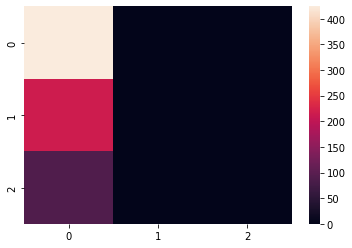

In [24]:
output = np.argmax(predictions.predictions,1)
sns.heatmap(confusion_matrix(test.label.values,output))#,labels = ['1','-1','0']

In [25]:
confusion_matrix(test.label.values,output)

array([[424,   0,   0],
       [214,   0,   0],
       [ 89,   0,   0]], dtype=int64)

In [26]:
# Try with finbert 
#  define tokenizer & model --> this is just a change from the previous code above
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# turn the configuration for a 3 sentiment classification task
config = AutoConfig.from_pretrained("ProsusAI/finbert")
config.num_labels = 3

finbert_model = AutoModelForSequenceClassification.from_config(config)

# redefine our datasets as wechanged the tokenizer 

MAX_LEN = 128
train_ds = BERTTutorialDataset(
    input_data=train['sentence'].to_numpy(),
        sentiment_targets=train['label'].to_numpy(),
        tokenizer=finbert_tokenizer,
        max_len=MAX_LEN
    )
val_ds = BERTTutorialDataset(
    input_data=val['sentence'].to_numpy(),
        sentiment_targets=val['label'].to_numpy(),
        tokenizer=finbert_tokenizer,
        max_len=MAX_LEN
    )

test_ds = BERTTutorialDataset(
    input_data=test['sentence'].to_numpy(),
        sentiment_targets=test['label'].to_numpy(),
        tokenizer=finbert_tokenizer,
        max_len=MAX_LEN
    )


loading configuration file https://huggingface.co/ProsusAI/finbert/resolve/main/config.json from cache at C:\Users\drago/.cache\huggingface\transformers\2120f4f96b5830e5a91fe94d242471b0133b0976c8d6e081594ab837ac5f17bc.ef97278c578016c8bb785f15296476b12eae86423097fed78719d1c8197a3430
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "ab

In [27]:
# Define trainning arguments 
training_args = TrainingArguments('BERT_TUTORIAL_MODEL', overwrite_output_dir=True, evaluation_strategy="steps", 
                                  num_train_epochs=50, weight_decay=0.005,learning_rate=1e-4,
                                  eval_steps=200,metric_for_best_model='accuracy',
                                 per_device_train_batch_size=16, per_device_eval_batch_size=16,
                                 load_best_model_at_end = True, save_total_limit=10, save_steps=200,no_cuda=False,
                             fp16=True,gradient_accumulation_steps=4)
trainer = Trainer(
    model =finbert_model, args=training_args, train_dataset=train_ds, eval_dataset=val_ds,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=20)], compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 3633
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 2850


Step,Training Loss,Validation Loss


In [ ]:
trainer.evaluate(test_ds)

## 4. Visualisation

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

To visualise which words in each phrase are the most important for the prediction we will use the python package transformers_interpret 

In [ ]:
fin_model_name = "ProsusAI/finbert"
model_name = "textattack/bert-base-uncased-SST-2"


fin_model = AutoModelForSequenceClassification.from_pretrained(fin_model_name)
fin_tokenizer = AutoTokenizer.from_pretrained(fin_model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# With both the model and tokenizer initialized we are now able to get explanations on an example text.
cls_explainer = SequenceClassificationExplainer(model,
                                                tokenizer)

fin_cls_explainer = SequenceClassificationExplainer(fin_model,
                                                    fin_tokenizer)

In [ ]:
word_attributions = cls_explainer("Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing")
word_attributions = fin_cls_explainer("Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing")

In [ ]:
cls_explainer.predicted_class_name

In [ ]:
bert_vis = cls_explainer.visualize()

In [ ]:
fin_bert_vis = fin_cls_explainer.visualize()